Read in packages and set up environment

In [8]:
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.patches import Patch
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as mtick
import os
import fiona
import rasterio.plot
import matplotlib as mpl
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
import pycrs
from pyproj import CRS
# from descartes import PolygonPatch
from PIL import Image
import matplotlib.colors as colors
from mycolorpy import colorlist as mcp
import matplotlib.patches as mpatches
from my_functions import *

# os.chdir("C:/Users/gy17m2a/OneDrive - University of Leeds/PhD/DataAnalysis/FloodModelling/")
# os.chdir("../../../FloodModelling")

# Define whether to filter out values <0.1
remove_little_values = True

Define methods for splitting into multiple peaks, and shorthands ways to refer to them used in filepaths

In [2]:
### Define the names of the methods, and the shorthand versions of the names used in the folder naming conventions
methods =  {'singlepeak' : 'sp', 'dividetime' : 'dt', 'subpeaktiming' : 'sp-t', 'maxspread': 'ms'}

In [3]:
breaks_depths = np.array([0.3, 0.6,1.2,100])  
labels_depth = ['<=0.3', '0.3-0.6m', '0.6-1.2m', '>1.2m']
breaks_velocity = np.array([0,0.25,0.5,2,100])
labels_velocity = ["<=0.25m/s", "0.25-0.5m/s", "0.5-2m/s", ">2m/s"]

#### Read in rasters containing depths and extents using each of the methods
Store these in a dictionary

For each method, read in the raster file containing the depth and velocity values and convert to array.   
If "remove_little_values" is True, and therefore we want to consider only cells with flooding > 0.1m then: set any values in the depth array which are less than 0.1 to 0, and also set the equivalent cells in the velocity values array to 0.

In [6]:
# Create dictionaries to store the rasters for both depth and velocity
depth_rasters_dict = {}
velocity_rasters_dict = {}

# Populate the dictionaries with the depth/velocity rasters
# Filter out values which have a depth of <0.1m
for key, value in methods.items():
    
    # Clip the raster files
    velocity_raster, out_meta = open_and_clip("MeganModel/6hr_{}_u/6hr_{}_velocity.Resampled.Terrain.tif".format(value, key),
                               "MeganModel/6hr_{}_u/6hr_{}_velocity.Resampled.Terrain_clipped.tif".format(value, key))    
    depth_raster, out_meta = open_and_clip("MeganModel/6hr_{}_u/6hr_{}_depth.Resampled.Terrain.tif".format(value, key),
                               "MeganModel/6hr_{}_u/6hr_{}_depth.Resampled.Terrain_clipped.tif".format(value, key))   
    # Set -9999 to NA
    velocity_raster[velocity_raster < -9998] = np.nan
    depth_raster[depth_raster < -9998] = np.nan    
    # Set cell values to Null in cells which have a value <0.1 in the depth raster
    if remove_little_values == True:
            depth_raster[depth_raster < 0.1] = 0
            velocity_raster[velocity_raster < 0.1] = 0
    # Save to dictionary 
    depth_rasters_dict[key] = depth_raster
    velocity_rasters_dict[key] = velocity_raster

In [23]:
# classified_depth = np.sum(np.dstack([(depth_rasters_dict[key] > b) for b in breaks_depths]), axis=2).astype(np.int32)   
# classified_depth = np.where(np.isnan(depth_rasters_dict[key]), np.nan, classified_depth)   
# save_array_as_raster(classified_depth, "Arcpy/classified_depth_{}.tiff".format(key),out_meta) 
# plot_classified_depth("Arcpy/classified_depth_{}.tiff".format(key), "Arcpy/Figs/classified_depth_{}.png".format(key),
#                      labels_depth)    

#### Create versions of depth/velocity rasters which are classified into depth/velocity categories

In [31]:
# Populate the dictionaries with the depth/velocity rasters
# Filter out values which have a depth of <0.1m
for key, value in methods.items():

    # Classify
    classified_depth = np.sum(np.dstack([(depth_rasters_dict[key] > b) for b in breaks_depths]), axis=2).astype(np.int32)   
    classified_velocity = np.sum(np.dstack([(velocity_rasters_dict[key] > b) for b in breaks_velocity]), axis=2).astype(np.int32)
    
    # Reset the np.nans as np.nans
    classified_depth = np.where(np.isnan(depth_rasters_dict[key]), np.nan, classified_depth)
    classified_velocity = np.where(np.isnan(velocity_rasters_dict[key]), np.nan, classified_velocity)
    
    # Save
    save_array_as_raster(classified_depth, "Arcpy/classified_depth_{}.tiff".format(key),out_meta) 
    plot_classified_depth("Arcpy/classified_depth_{}.tiff".format(key), "Arcpy/Figs/classified_depth_{}.png".format(key),
                         labels_depth)    
        
    save_array_as_raster(classified_velocity, "Arcpy/classified_velocity_{}.tiff".format(key),out_meta)
    plot_classified_velocity("Arcpy/classified_velocity_{}.tiff".format(key), "Arcpy/Figs/classified_velocity_{}.png".format(key),
                           labels_velocity) 
    
#     ######################################################################################
#     ######################################################################################
#     # Find difference between depth/velocity rasters from this method, and the single peak method
#     ######################################################################################
#     ######################################################################################
#     if key != 'singlepeak':
#         # Depth
#         depth_difference_raster = depth_rasters_dict['singlepeak'] - depth_rasters_dict[key]
#         # Velocity
#         velocity_difference_raster = velocity_rasters_dict['singlepeak'] - velocity_rasters_dict[key]
#         # Save 
#         save_array_as_raster(depth_difference_raster, "Arcpy/depth_singlepeak_{}_diff.tiff".format(key),out_meta)
#         plot("Arcpy/depth_singlepeak_{}_diff.tiff".format(key), "Arcpy/Figs/depth_singlepeak_{}_diff.png".format(key))    
        
#         save_array_as_raster(velocity_difference_raster, "Arcpy/velocity_singlepeak_{}_diff.tiff".format(key),out_meta)  
#         plot("Arcpy/velocity_singlepeak_{}_diff.tiff".format(key), "Arcpy/Figs/velocity_singlepeak_{}_diff.png".format(key))  
        
#         ######################################################################################
#         ######################################################################################
#         # Reclassify the difference rasters to represent whether value is positive or negative 
#         ######################################################################################
#         ######################################################################################
#         breaks_pos_neg = np.array([-10000, 0, 10000])    

#         # Depth
#         pos_neg_depth_diff = np.where(np.isnan(depth_difference_raster), np.nan,
#                                       np.where(depth_difference_raster <0, 0, 1))
#         save_array_as_raster(pos_neg_depth_diff, "Arcpy/depth_singlepeak_{}_diff_reclassified.tif".format(key),out_meta)  
#         plot("Arcpy/depth_singlepeak_{}_diff_reclassified.tif".format(key), "Arcpy/Figs/depth_singlepeak_{}_diff_reclassified.png".format(key))    
        
#         # Velocity
#         pos_neg_velocity_diff = np.where(np.isnan(velocity_difference_raster), np.nan,
#                                       np.where(velocity_difference_raster <0, 0, 1))
#         save_array_as_raster(pos_neg_velocity_diff, "Arcpy/velocity_singlepeak_{}_diff_reclassified.tif".format(key),out_meta)   
#         plot("Arcpy/velocity_singlepeak_{}_diff_reclassified.tif".format(key), "Arcpy/Figs/velocity_singlepeak_{}_diff_reclassified.png".format(key))  


### Find the proportion of cells in the catchment which were flooded with particular depths or velocities
Explanation

In [15]:
results_dict = {}
for variable in ["depth", "velocity"]:
    counts_df = pd.DataFrame()
    proportions_df = pd.DataFrame()        

    for method_name, shortening in methods.items():    # Define filepath
        if variable == 'depth':
            raster = depth_rasters_dict[method_name]
        elif variable == 'velocity':
            raster = velocity_rasters_dict[method_name]
            
        unique, counts = np.unique(raster, return_counts=True)
        df = pd.DataFrame({'values': unique, 'counts':counts})

        # Cut by depth bins
        if variable == 'depth':
            df['bins']= pd.cut(unique, bins=breaks_depths, right=False)
        elif variable == 'velocity':
            df['bins']= pd.cut(unique, bins=breaks_velocity, right=False)
        groups = df.groupby(['bins']).sum()
        groups  = groups.reset_index()
        # Find the sum
        total_n_cells = groups ['counts'].sum()
        # Find the number of cells in each group as a proportion of the total
        groups['Proportion'] = round((groups['counts']/total_n_cells) *100,1)
        
        # Add values to dataframes
        counts_df[method_name] = groups['counts']
        proportions_df[method_name] = groups['Proportion']
        
    # Reset index to show the groups
    counts_df.reset_index(inplace=True)
    proportions_df.reset_index(inplace=True)
    
    # Set index values
    if variable == 'depth':
        counts_df['index'] = labels_depth
        proportions_df['index'] = labels_depth
    elif variable == 'velocity':
        counts_df['index'] = labels_velocity
        proportions_df['index'] = labels_velocity

    # Add to dictionary
    results_dict['{}_counts'.format(variable)] = counts_df
    results_dict['{}_props'.format(variable)] = proportions_df   

ValueError: Length of values (4) does not match length of index (3)

Create a dataframe for both depth and velocity showing the number of cells with flooding with certain depths and velocities

#  Flood extent and depth

In [40]:
# Create one dataframe with each column the total number of flooded cells for each method 
variable = 'velocity'
counts_df = results_dict['{}_counts'.format(variable)]
# totals_df = counts_df.append(counts_df.sum(numeric_only=True), ignore_index=True)
totals_df =pd.DataFrame(counts_df.sum(numeric_only=True)).T
totals_df = totals_df.iloc[[len(totals_df)-1]]
# totals_df.drop(columns = 'index', inplace = True)

# Convert this to the total flooded area for each method
totals_df_area = (totals_df * 25)/1000000

In [44]:
# Get a list of the percentage difference between the total number of flooded cells with a single peak and the methods for
# creating multiple peaks
ls = []
for method in methods.keys():
    if method!= 'singlepeak':
        ls.append((totals_df[method]/totals_df['singlepeak'] - 1).map('{:.2%}'.format).values[0])
ls = ['+'  + s for s in ls]
ls = [''] + ls

## Does the temporal profile affect the total number of flooded cells and the total flooded area?
This is assuming grid cells are 5m by 5m - but need to check this is correct.  
This plot is the same whether you use depth or velocity as the variable

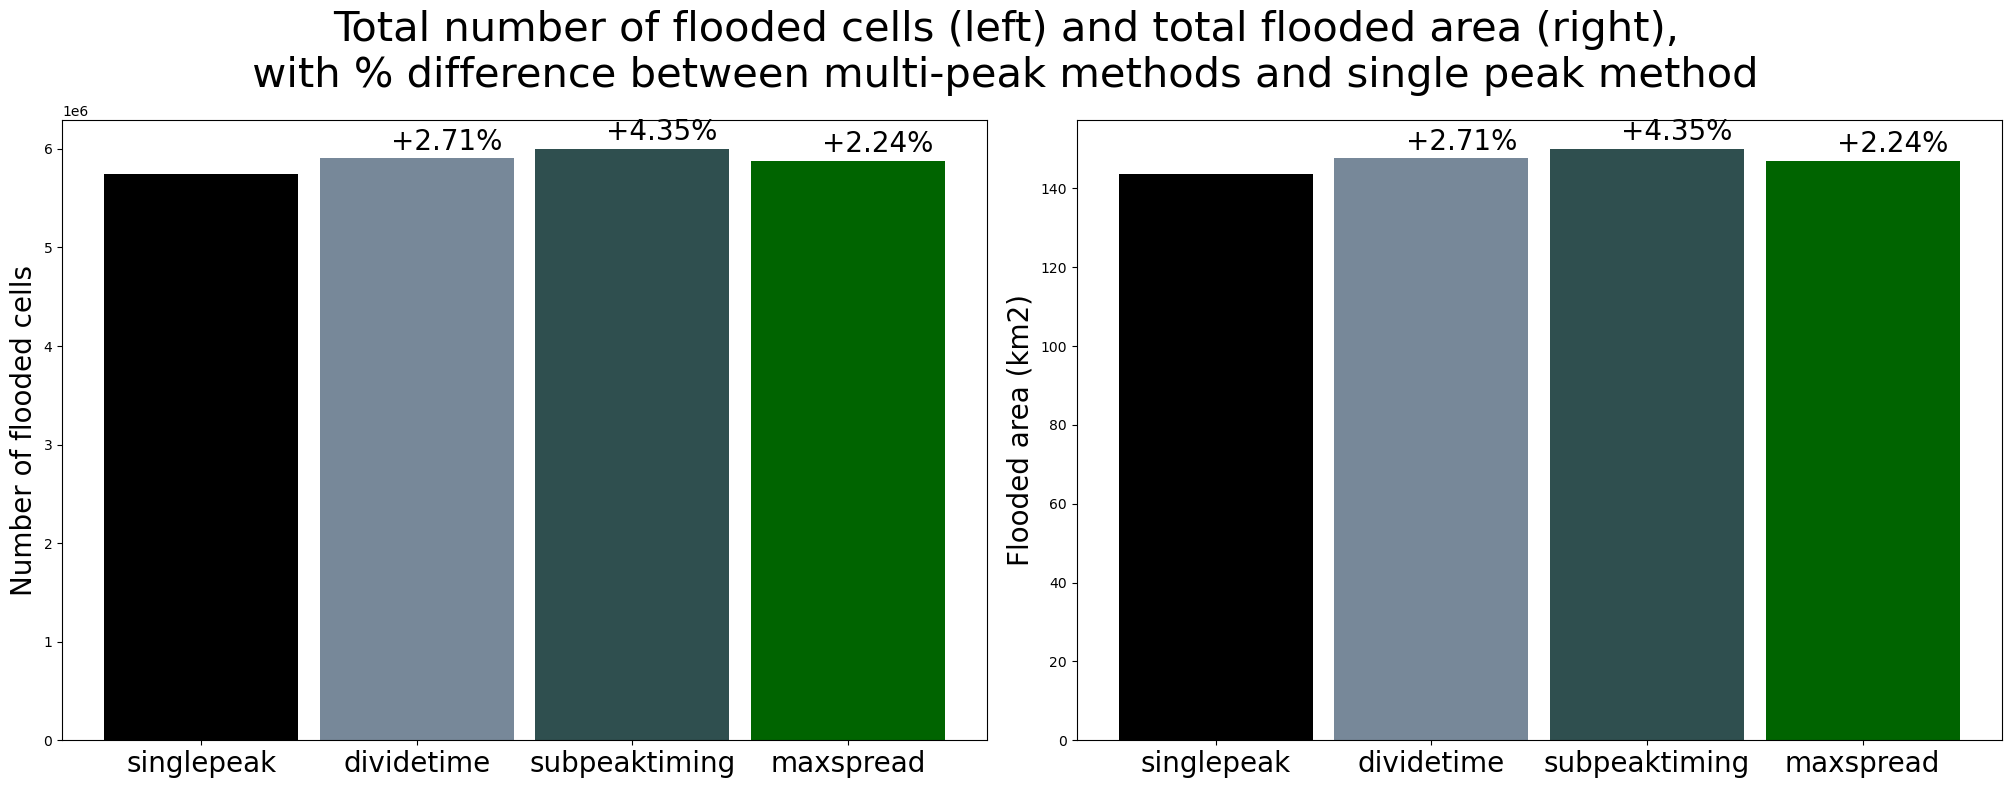

In [138]:
# Set colors for plots
colors = ['black', 'lightslategrey', 'darkslategrey', 'darkgreen']

fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize = (20,14))
y_pos = np.arange(len(methods.keys()))

##############################
# Plot number of flooded cells
##############################
plt.subplot(221)
plt.bar(y_pos, totals_df.iloc[[0]].values.tolist()[0], color=colors,
        width = 0.9)
# Create names on the x-axis
plt.xticks(y_pos, methods.keys(), fontsize =20)
# plt.xlabel('Method')
plt.ylabel('Number of flooded cells', fontsize =20)

xlocs, xlabs = plt.xticks()
xlocs=[i+1 for i in range(0,10)]
xlabs=[i/2 for i in range(0,10)]

for i, v in enumerate(totals_df.iloc[[0]].values.tolist()[0]):
    plt.text(xlocs[i] - 1.12, v * 1.015, str(ls[i]), fontsize = 20)

# ##############################
# # Plot flooded extent in m2
# ##############################
plt.subplot(222)
plt.bar(y_pos, totals_df_area.iloc[[0]].values.tolist()[0], color=colors,
        width = 0.9)
# Create names on the x-axis
plt.xticks(y_pos, methods.keys(), fontsize =20 )
# plt.xlabel('Method')
plt.ylabel('Flooded area (km2)', fontsize =20 )

xlocs, xlabs = plt.xticks()
xlocs=[i+1 for i in range(0,10)]
xlabs=[i/2 for i in range(0,10)]

for i, v in enumerate(totals_df_area.iloc[[0]].values.tolist()[0]):
    plt.text(xlocs[i] - 1.12, v * 1.015, str(ls[i]), fontsize = 20)

st = plt.suptitle ("Total number of flooded cells (left) and total flooded area (right),\n with % difference between multi-peak methods and single peak method ", fontsize = 30)

# Is there spatial variation in the resulting flood extent and depth between different temporal rainfall profiles?

Does the temporal rainfall profile influence the spatial distribution of the flood extent different flood extents?

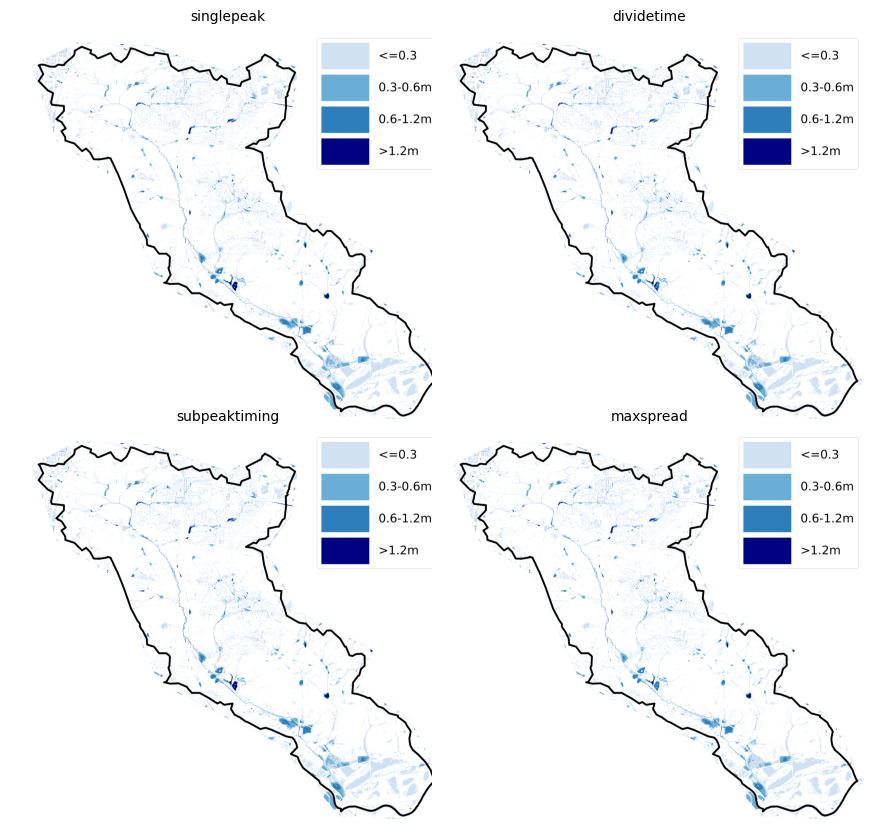

In [39]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(30,20))
subplot_n = [221, 222, 223, 224]
subplot_i = 0

for subplot_i, method in enumerate(methods):
    img = Image.open("Arcpy/Figs/classified_depth_{}.png".format(method))
    plt.subplot(subplot_n[subplot_i])
    plt.axis('off')
    plt.imshow(img)
    plt.title(method, fontsize = 10)
fig.tight_layout()
plt.subplots_adjust(left=0.125,bottom=0.1, right=0.5, top=0.5, wspace=-0.4, hspace=0)
# plt.show()    
plt.show()

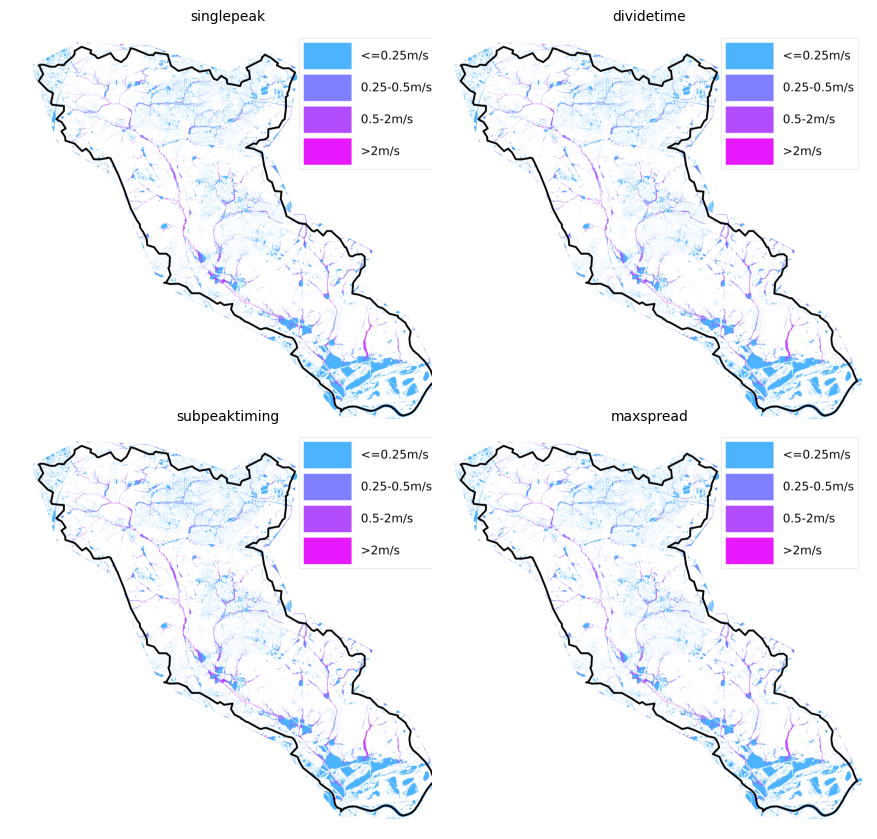

In [40]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(30,20))
subplot_n = [221, 222, 223, 224]
subplot_i = 0

for subplot_i, method in enumerate(methods):
    img = Image.open("Arcpy/Figs/classified_velocity_{}.png".format(method))
    plt.subplot(subplot_n[subplot_i])
    plt.axis('off')
    plt.imshow(img)
    plt.title(method, fontsize = 10)
fig.tight_layout()
plt.subplots_adjust(left=0.125,bottom=0.1, right=0.5, top=0.5, wspace=-0.4, hspace=0)
# plt.show()    
plt.show()

###  Plot the number and proportion of flooded cells with different depth and velocity categories

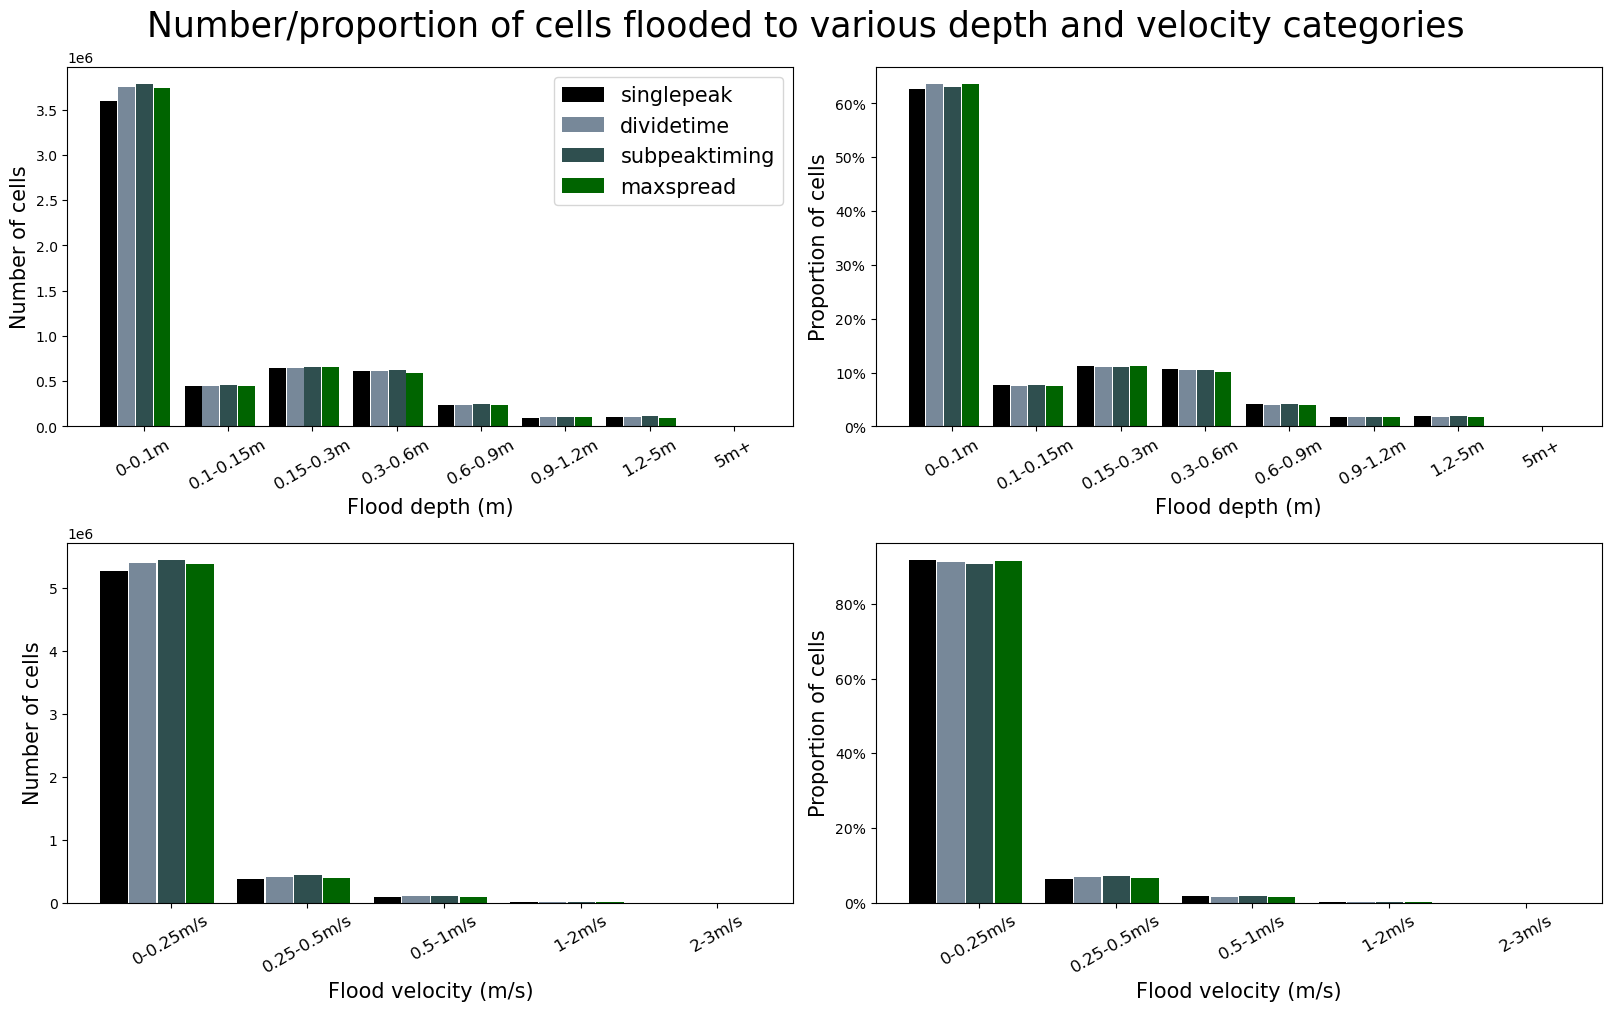

In [36]:
fig, axs = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize = (16,10))
fig.suptitle('Number/proportion of cells flooded to various depth and velocity categories', fontsize = 25)
subplot_n = [221, 222, 223, 224]
subplot_i = 0

units_dict = {'depth': 'm', 'velocity': 'm/s'}    

for row, variable in enumerate(["depth", "velocity"]):

    counts_df = results_dict['{}_counts'.format(variable)]
    proportions_df = results_dict['{}_props'.format(variable)]
    
    ################# Plot
    labels = counts_df['index']
    x = np.arange(len(counts_df['index']))
    width = 0.3
    
    # counts_df plotting
    width, DistBetweenBars, Num = 0.2, 0.01, 4 # width of each bar, distance between bars, number of bars in a group
    # calculate the width of the grouped bars (including the distance between the individual bars)
    WithGroupedBars = Num*width + (Num-1)*DistBetweenBars
    plt.subplot(subplot_n[subplot_i])
    for i in range(Num):
        plt.bar(np.arange(len(counts_df))-WithGroupedBars/2 + (width+DistBetweenBars)*i, counts_df.iloc[:,i+1], width, 
                color = colors[i])
    plt.xticks(np.arange(len(counts_df['index'])), counts_df['index'], rotation=30, fontsize = 12)
    plt.xlabel('Flood {} ({})'.format(variable, units_dict[variable]), fontsize = 15)
    plt.ylabel('Number of cells', fontsize = 15)
    # Put legend on top left plot
    if subplot_i == 0:
        plt.legend(counts_df.columns[1:], fontsize=15, frameon = True)
   
    # Proportions_df plotting
    subplot_i = subplot_i+ 1        
    plt.subplot(subplot_n[subplot_i])
    for i in range(Num):
        plt.bar(np.arange(len(counts_df))-WithGroupedBars/2 + (width+DistBetweenBars)*i, proportions_df.iloc[:,i+1], width, 
                color = colors[i])
    plt.xticks(np.arange(len(proportions_df['index'])), proportions_df['index'], rotation=30, fontsize = 12)
    plt.xlabel('Flood {} ({})'.format(variable, units_dict[variable]), fontsize = 15)
    plt.ylabel('Proportion of cells', fontsize = 15)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
    subplot_i = subplot_i+ 1 


# Question about severity of flooding, rather than just extent?

### Stacked bar chart - plotting the total number of flood cells with breakdown by categories

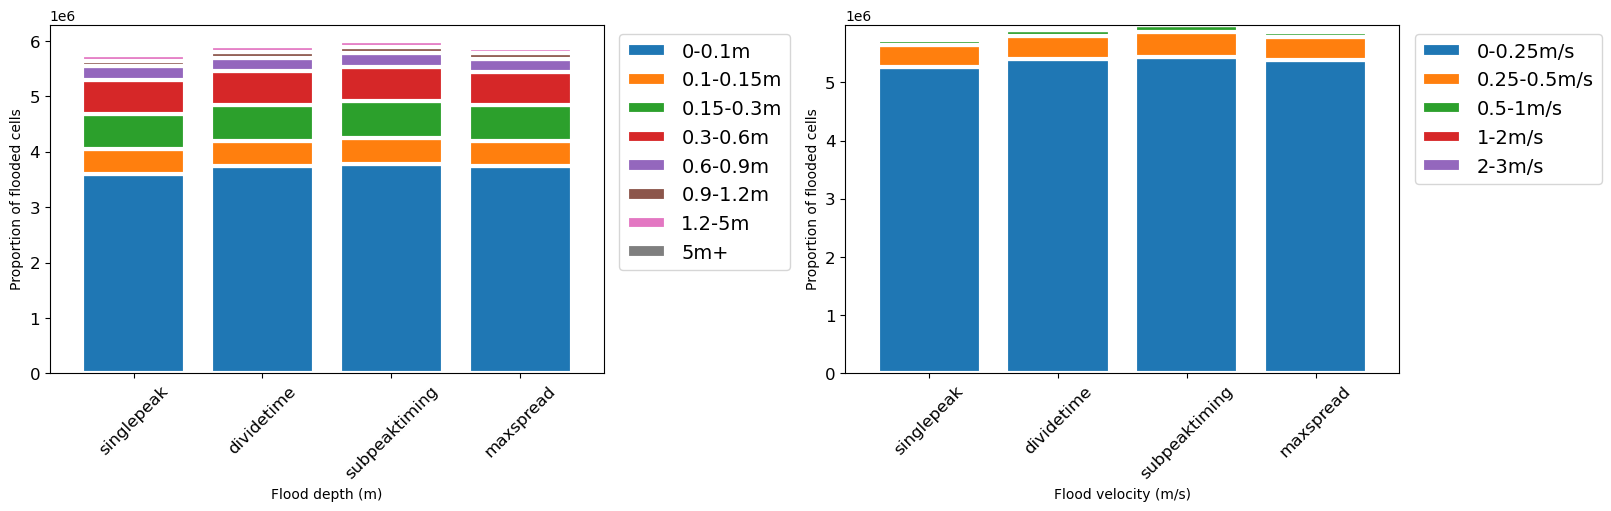

In [37]:
fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize = (16,5))
# fig.suptitle('Number/proportion of cells flooded to various depth and velocity categories', fontsize = 25)
subplot_n = [221, 222]
subplot_i = 0

units_dict = {'depth': 'm', 'velocity': 'm/s'}    

for row, variable in enumerate(["depth", "velocity"]):
    # Get the dataframes
    counts_df = results_dict['{}_counts'.format(variable)]
    proportions_df = results_dict['{}_props'.format(variable)]
    
    # reformat the dataframe for stacked plotting
    reformatted_df  =counts_df.T[1:]
    if row == 1:
        reformatted_df.columns = ['0-0.25m/s', '0.25-0.5m/s', '0.5-1m/s','1-2m/s', '2-3m/s']
    else:
        reformatted_df.columns = ['0-0.1m', '0.1-0.15m', '0.15-0.3m', '0.3-0.6m', '0.6-0.9m', '0.9-1.2m', '1.2-5m', '5m+']
    # Plot   
    reformatted_df.plot(ax=axs[row], kind='bar', edgecolor='white', linewidth=3, stacked = True, width =0.8, rot =45,
                         xlabel = 'Flood {} ({})'.format(variable, units_dict[variable]),
                            ylabel = 'Proportion of flooded cells', fontsize = 12)
    
    plt.rcParams.update({'font.size': 14})
    axs[row].legend(bbox_to_anchor=(1.01, 1), loc='upper left')

### Stacked bar chart - proportion of total num flooded cells made up by each depth/velocity category

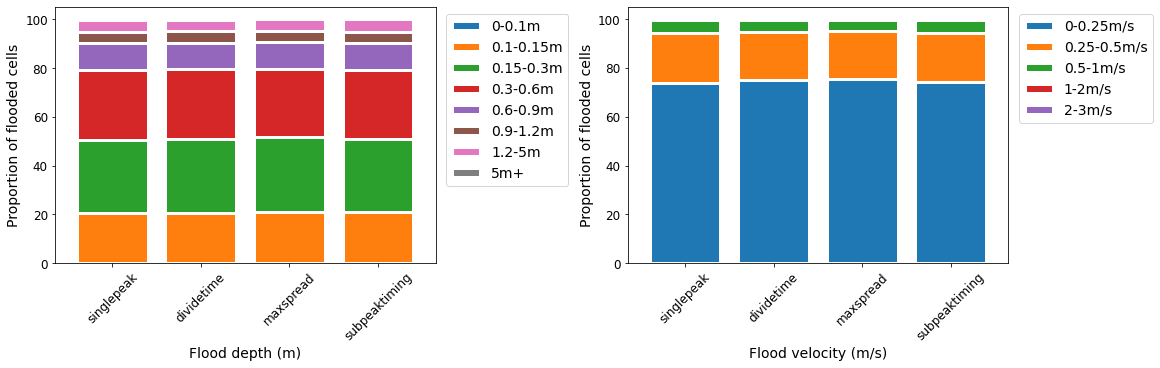

In [201]:
fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize = (16,5))
# fig.suptitle('Number/proportion of cells flooded to various depth and velocity categories', fontsize = 25)
subplot_n = [221, 222]

units_dict = {'depth': 'm', 'velocity': 'm/s'}    

for row, variable in enumerate(["depth", "velocity"]):
    # Get the dataframes
    counts_df = results_dict['{}_counts'.format(variable)]
    proportions_df = results_dict['{}_props'.format(variable)]
    
    # reformat the dataframe for stacked plotting
    reformatted_df  =proportions_df.T[1:]
    if row == 1:
        reformatted_df.columns = ['0-0.25m/s', '0.25-0.5m/s', '0.5-1m/s','1-2m/s', '2-3m/s']
    else:
        reformatted_df.columns = ['0-0.1m', '0.1-0.15m', '0.15-0.3m', '0.3-0.6m', '0.6-0.9m', '0.9-1.2m', '1.2-5m', '5m+']
    # Plot
#     width = 1 / len(bar_lefts)
    reformatted_df.plot(ax=axs[row], kind='bar', edgecolor='white', linewidth=3, stacked = True, width =0.8, rot =45,
                         xlabel = 'Flood {} ({})'.format(variable, units_dict[variable]),
                            ylabel = 'Proportion of flooded cells', fontsize = 12)
#     reformatted_df.plot.bar(ax=axs[row], rot=0, stacked = True, xlabel = 'Flood {} ({})'.format(variable, units_dict[variable]),
#                             ylabel = 'Proportion of flooded cells', fontsize = 12)
    plt.rcParams.update({'font.size': 14})
    axs[row].legend(bbox_to_anchor=(1.01, 1), loc='upper left')

In [25]:
# Create dictionaries to store the rasters for both depth and velocity
depth_rasters_dict = {}
velocity_rasters_dict = {}

# Populate the dictionaries with the depth/velocity rasters
# Filter out values which have a depth of <0.1m
for key, value in methods.items():
    print(key)
    # Read in the raster files
    velocity_raster = rasterio.open("MeganModel/6hr_{}_u/6hr_{}_velocity.Resampled.Terrain.tif".format(value, key)).read(1)
    depth_raster = rasterio.open("MeganModel/6hr_{}_u/6hr_{}_depth.Resampled.Terrain.tif".format(value, key)).read(1)
    # Set -9999 to NA
    velocity_raster[velocity_raster < -9998] = np.nan
    depth_raster[depth_raster < -9998] = np.nan    
    # Set cell values to Null in cells which have a value <0.1 in the depth raster
    if remove_little_values == True:
            depth_raster[depth_raster < 0.1] = 0
            velocity_raster[velocity_raster < 0.1] = 0
    # Save to dictionary 
    depth_rasters_dict[key] = depth_raster
    velocity_rasters_dict[key] = velocity_raster

singlepeak
dividetime
subpeaktiming
maxspread


#### Find the worst depth and velocity value in each grid cell (across all 4 methods), and the method that lead to worst case where: 0 = maxspread, 1 = singlepeak, 2 = subpeaktiming, 3 = dividetime


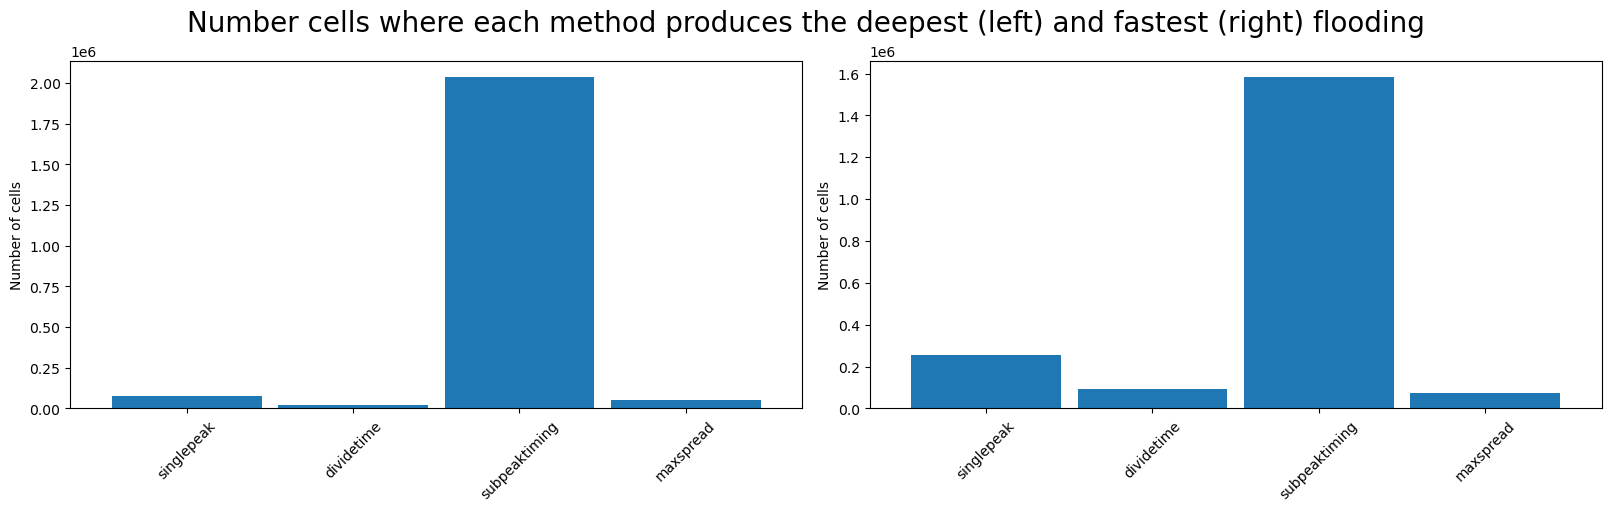

In [26]:
fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize = (16,5))
fig.suptitle('Number cells where each method produces the deepest (left) and fastest (right) flooding', fontsize = 20)
subplot_n = [221, 222]
subplot_i = 0

for row, variable in enumerate(["depth", "velocity"]):
    if variable == 'depth':
        rasters_dict = depth_rasters_dict
    else:
        rasters_dict = velocity_rasters_dict
        
    worst_case_values =np.where((rasters_dict['singlepeak'] > rasters_dict['dividetime']) & (rasters_dict['singlepeak'] > rasters_dict['maxspread']) & (rasters_dict['singlepeak'] > rasters_dict['subpeaktiming']), rasters_dict['singlepeak'],
                         np.where((rasters_dict['dividetime'] > rasters_dict['subpeaktiming']) & (rasters_dict['dividetime'] > rasters_dict['maxspread']) & (rasters_dict['dividetime'] > rasters_dict['singlepeak']),rasters_dict['dividetime'],
                         np.where((rasters_dict['subpeaktiming'] > rasters_dict['dividetime']) & (rasters_dict['subpeaktiming'] > rasters_dict['maxspread']) & (rasters_dict['subpeaktiming'] > rasters_dict['singlepeak']), rasters_dict['subpeaktiming'],  
                         np.where((rasters_dict['maxspread'] > rasters_dict['dividetime']) & (rasters_dict['maxspread'] > rasters_dict['singlepeak']) & (rasters_dict['maxspread'] > rasters_dict['subpeaktiming']), rasters_dict['maxspread'],  
                         np.nan))))     

    worst_case_method =  np.where((rasters_dict['singlepeak'] > rasters_dict['dividetime']) & (rasters_dict['singlepeak'] > rasters_dict['maxspread']) & (rasters_dict['singlepeak'] > rasters_dict['subpeaktiming']), 0, 
                               np.where((rasters_dict['dividetime'] > rasters_dict['subpeaktiming']) & (rasters_dict['dividetime'] > rasters_dict['maxspread']) & (rasters_dict['dividetime'] > rasters_dict['singlepeak']),1,                    
                                np.where((rasters_dict['subpeaktiming'] > rasters_dict['dividetime']) & (rasters_dict['subpeaktiming'] > rasters_dict['maxspread']) & (rasters_dict['subpeaktiming'] > rasters_dict['singlepeak']), 2,  
                                np.where((rasters_dict['maxspread'] > rasters_dict['dividetime']) & (rasters_dict['maxspread'] > rasters_dict['singlepeak']) & (rasters_dict['maxspread'] > rasters_dict['subpeaktiming']), 3,   
                               np.nan))))     
    
    unique, counts = np.unique(worst_case_method, return_counts=True)
    worst_case_method_df = pd.DataFrame({'values': unique, 'counts':counts})
    
    worst_case_method_df = worst_case_method_df.iloc[:4,1]
    worst_case_method_df
    worst_case_method_df.index = ["singlepeak", "dividetime", "subpeaktiming", "maxspread"]
    worst_case_method_df.plot(ax= axs[row], kind ='bar',width=  0.9, rot =45, ylabel = 'Number of cells')    

In [68]:
def plotting_raster (raster_fp):
    # Catchment boundary shapefile
    my_shp = "C:/Users/gy17m2a/OneDrive - University of Leeds/PhD/DataAnalysis/FloodModelling/MeganModel/CatchmentLinDyke_exported.shp"
    gdf = gpd.read_file(my_shp)
    
    # Specficy output to save output to (temporary - is then deleted)
    out_tif = "test.tif"
    
    # Read in the raster data
    data = rasterio.open(raster_fp)
    raster = data.read(1)

    # Create a bounding box 
    minx, miny = 437000,  426500
    maxx, maxy = 445500, 434300
    bbox = box(minx, miny, maxx, maxy)
    # Insert the bbox into a GeoDataFrame
    geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=CRS('EPSG:27700'))     
    # Re-project into the same coordinate system as the raster data
    geo = geo.to_crs(crs=CRS('EPSG:27700'))#data.crs.data

    # Next we need to get the coordinates of the geometry in such a format
    # that rasterio wants them. This can be conducted easily with following function
    def getFeatures(gdf):
        """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
        import json
        return [json.loads(gdf.to_json())['features'][0]['geometry']]
    # Get the geometry coordinates by using the function.
    coords = getFeatures(geo)

    # Clip the raster with the polygon using the coords variable that we just created. Clipping the raster can be done easily 
    # with the mask function and specifying clip=True.
    out_img, out_transform = mask(data, shapes=coords, crop=True)

    # Modify the metadata. Let’s start by copying the metadata from the original data file.
    out_meta = data.meta.copy()
    # Parse the EPSG value from the CRS so that we can create a Proj4 string using PyCRS library 
    # (to ensure that the projection information is saved correctly) [this bit didn't work so specified manually]
    epsg_code = int(data.crs.data['init'][5:])
    # Now we need to update the metadata with new dimensions, transform (affine) and CRS (as Proj4 text)
    out_meta.update({"driver": "GTiff","height": out_img.shape[1],"width": out_img.shape[2], "transform": out_transform,
                     "crs": CRS('EPSG:27700')})#pycrs.parser.from_epsg_code(epsg_code).to_proj4()})

    # Save the clipped raster to disk with following command.
    with rasterio.open(
            out_tif, "w", **out_meta
    ) as dest_file:
        dest_file.write(out_img)
    dest_file.close()
    
        
    cmap = plt.cm.jet  # define the colormap
    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # force the first color entry to be grey
    cmaplist[0] = (.5, .5, .5, 1.0)

    # create the new map
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
    
        
    ############################
    ############################
    # PLotting
    ############################
    ############################
    fig, ax = plt.subplots(figsize=(20, 15))
    
    # Read back in the new clipped raster      
    clipped = rasterio.open(out_tif)
    
    # Add the catchment boundary to the plot
    ax = mpl.pyplot.gca()
    #rasterio.plot.show((clipped, 1), ax= ax, cmap = 'Blues')
    gdf.plot(ax=ax, facecolor = 'None', edgecolor = 'black', linewidth = 4)
    
    # Add the raster data to the plot
    # use imshow so that we have something to map the colorbar to
    image_hidden = ax.imshow(raster,  cmap=cmap) #  vmin=np.nanmin(raster), vmax=np.nanmax(raster))

    # plot on the same axis with rio.plot.show
    show((clipped, 1), ax=ax, cmap=cmap) # vmin=np.nanmin(raster),vmax=np.nanmax(raster))

    # add colorbar using the now hidden image
    cbar = fig.colorbar(image_hidden, ax=ax, fraction=0.06, pad=0.04)
    cbar.set_label(r'Depth (m)', fontsize=16)
    cbar.ax.tick_params(labelsize=15)

    clipped.close()

# plotting_raster ("Arcpy/classified_velocity.tiff")    

In [79]:
######################################################################################            
def save_array_as_raster(raster, fp_to_save):
    src = rasterio.open("MeganModel/6hr_{}_u/6hr_{}_velocity.Resampled.Terrain.tif".format(value, key))
    with rasterio.open(fp_to_save, 'w', driver='GTiff', height=raster.shape[0], width=raster.shape[1],
                            count=1, dtype=raster.dtype,crs=src.crs, nodata=np.nan, transform=src.transform) as dst:
             dst.write(raster, 1)      

            
for raster_name in depth_rasters_dict:
    print(raster_name)
    ######################################################################################
    ######################################################################################
    # Reclassify depth/velocity rasters into categories from Megan report
    ######################################################################################
    ######################################################################################

    # Classify
    classified_depth = np.sum(np.dstack([(depth_raster < b) for b in breaks_depths]), axis=2).astype(np.int32)   
    classified_velocity = np.sum(np.dstack([(velocity_raster < b) for b in breaks_velocity]), axis=2).astype(np.int32)
    
    # Reset the np.nans as np.nans
    classified_depth = np.where(np.isnan(depth_raster), np.nan, classified_depth)
    classified_velocity = np.where(np.isnan(depth_raster), np.nan, classified_velocity)
    
    save_array_as_raster(classified_depth, "Arcpy/classified_depth_{}.tiff".format(raster_name)) 
    save_array_as_raster(classified_velocity, "Arcpy/classified_velocity_{}.tiff".format(raster_name))  
    
    del classified_depth, classified_velocity
    

singlepeak
dividetime
subpeaktiming
maxspread


#### Plotting
From: https://automating-gis-processes.github.io/CSC18/lessons/L6/clipping-raster.html

In [85]:
fp = "MeganModel/6hr_dt_u/6hr_dividetime_velocity.Resampled.Terrain.tif"
fp = "Arcpy/temp.tiff"
data = rasterio.open(fp)
raster = data.read(1)
raster.shape

data

<open DatasetReader name='Arcpy/temp.tiff' mode='r'>

C:\Users\gy17m2a\Anaconda3\envs\pyproj_env\lib\site-packages\rasterio\__init__.py:277: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


ValueError: Input shapes do not overlap raster.

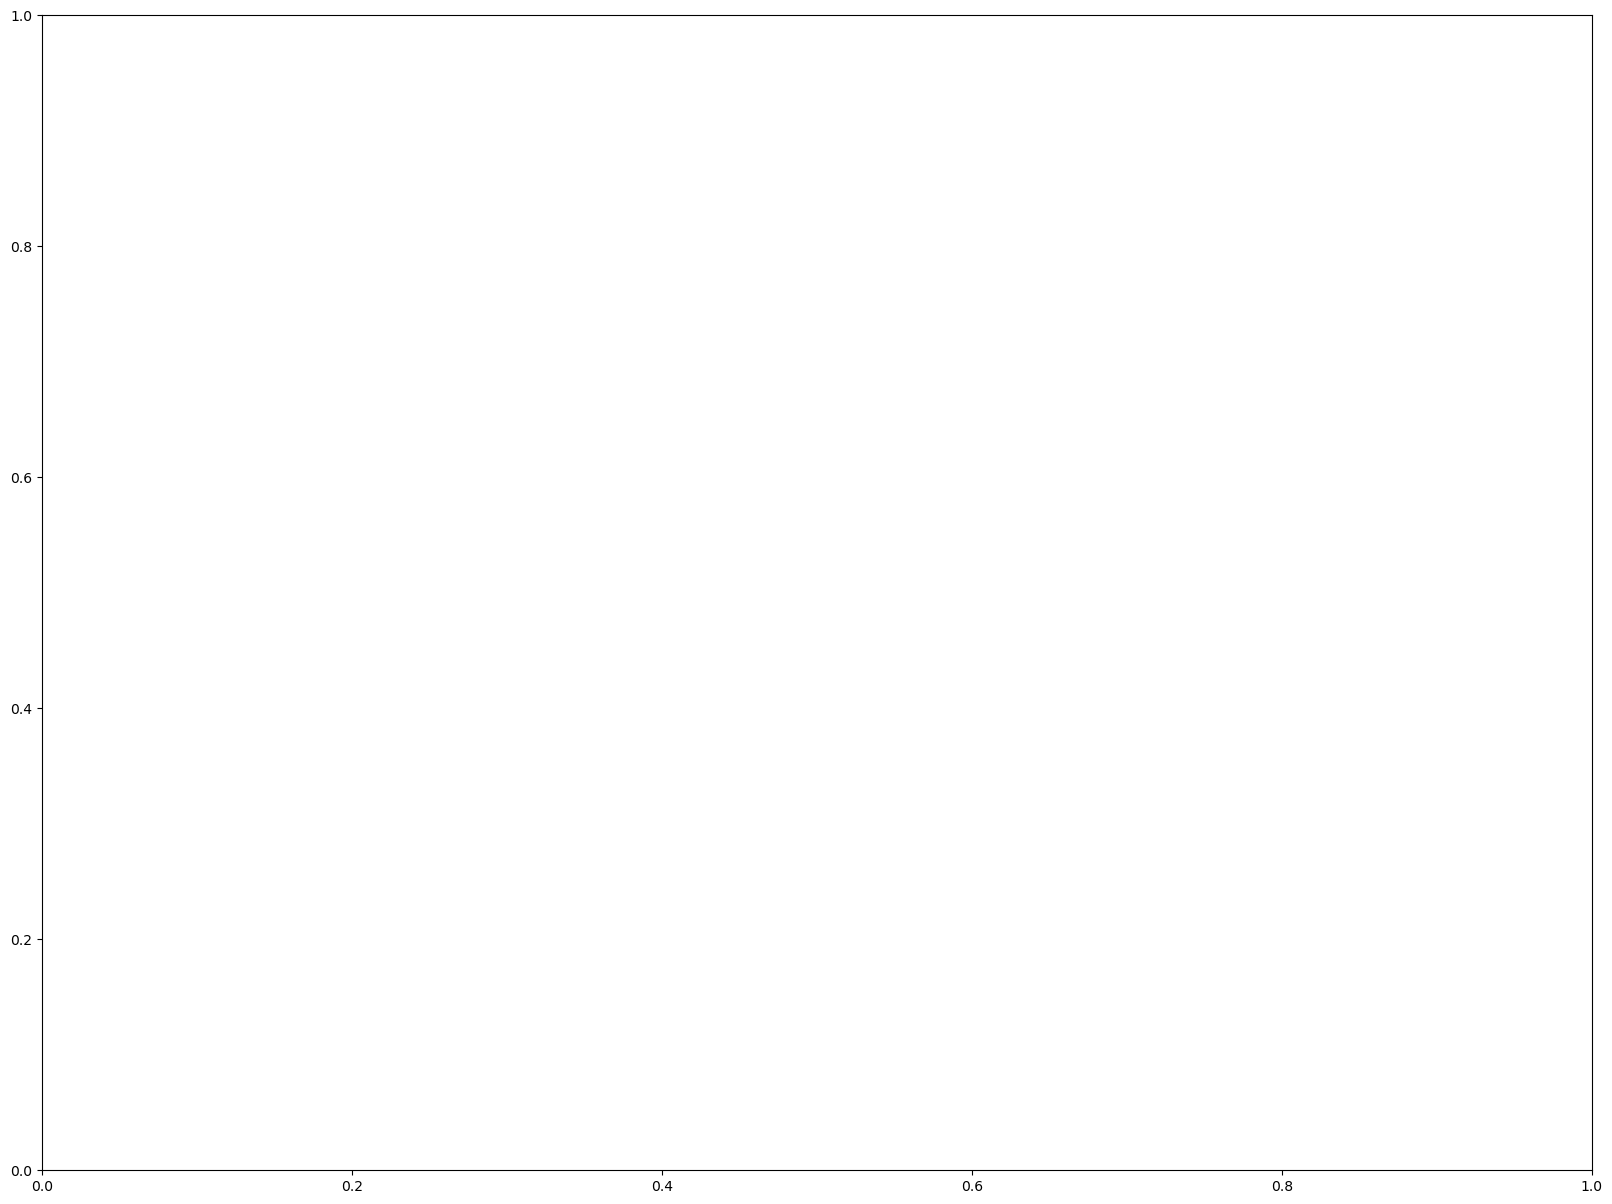

In [72]:
fig, ax = plt.subplots(figsize=(20, 15))

# Specify input and output filepaths
my_shp = "C:/Users/gy17m2a/OneDrive - University of Leeds/PhD/DataAnalysis/FloodModelling/MeganModel/CatchmentLinDyke_exported.shp"
gdf = gpd.read_file(my_shp)
out_tif = "test.tif"

# fp = "MeganModel/6hr_dt_u/6hr_dividetime_velocity.Resampled.Terrain.tif"
fp = "Arcpy/temp.tiff"
data = rasterio.open(fp)
raster = data.read(1)

# Create a bounding box 
minx, miny = 437000,  426500
maxx, maxy = 445500, 434300
bbox = box(minx, miny, maxx, maxy)
# Insert the bbox into a GeoDataFrame
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=CRS('EPSG:27700'))     
# Re-project into the same coordinate system as the raster data
geo = geo.to_crs(crs=CRS('EPSG:27700'))#data.crs.data

# Next we need to get the coordinates of the geometry in such a format
# that rasterio wants them. This can be conducted easily with following function
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]
# Get the geometry coordinates by using the function.
coords = getFeatures(geo)

# Clip the raster with the polygon using the coords variable that we just created. Clipping the raster can be done easily 
# with the mask function and specifying clip=True.
out_img, out_transform = mask(data, shapes=coords, crop=True)

# Modify the metadata. Let’s start by copying the metadata from the original data file.
out_meta = data.meta.copy()
# Parse the EPSG value from the CRS so that we can create a Proj4 string using PyCRS library 
# (to ensure that the projection information is saved correctly) [this bit didn't work so specified manually]
epsg_code = int(data.crs.data['init'][5:])
# Now we need to update the metadata with new dimensions, transform (affine) and CRS (as Proj4 text)
out_meta.update({"driver": "GTiff","height": out_img.shape[1],"width": out_img.shape[2], "transform": out_transform,
                 "crs": CRS('EPSG:27700')})#pycrs.parser.from_epsg_code(epsg_code).to_proj4()})

# Save the clipped raster to disk with following command.
with rasterio.open(
        out_tif, "w", **out_meta
) as dest_file:
    dest_file.write(out_img)
dest_file.close()
        
# plot the new clipped raster      
clipped = rasterio.open(out_tif)

ax = mpl.pyplot.gca()
rasterio.plot.show((clipped, 1), ax= ax, cmap = 'Blues')
gdf.plot(ax=ax, facecolor = 'None', edgecolor = 'black', linewidth = 4)

src = rasterio.open("MeganModel/6hr_dt_u/6hr_dividetime_velocity.Resampled.Terrain.tif")
fp  = "MeganModel/6hr_dt_u/6hr_dividetime_velocity.Resampled.Terrain.tif"
# use imshow so that we have something to map the colorbar to
image_hidden = ax.imshow(raster, 
                         cmap='Blues') 
#                          vmin=np.nanmin(raster), 
#                          vmax=np.nanmax(raster))

# plot on the same axis with rio.plot.show
show((clipped, 1), 
                      ax=ax, 
                      cmap='Blues') 
#                       vmin=np.nanmin(raster), 
#                       vmax=np.nanmax(raster))


# add colorbar using the now hidden image
cbar = fig.colorbar(image_hidden, ax=ax, fraction=0.06, pad=0.04)
cbar.set_label(r'Depth (m)', fontsize=16)
cbar.ax.tick_params(labelsize=15)

clipped.close()
# os.remove(out_tif)